#0. Setting up the Environment
Runtime -> Change runtime type -> Hardware accelerator -> GPU

In [ ]:
# Imports for this project
import json 
import os
from pathlib import Path
import zipfile
import os

import numpy as np
import pandas as pd
import seaborn as sns
import imageio
import matplotlib.pyplot as plt
import matplotlib

import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, Dataset
from PIL import Image

from torch.utils.data import random_split
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda import Device
from torch.autograd import Variable
from tqdm import tqdm

import random

#1. Downloading Data


In this section we download the data needed for our poject from Kaggle. The dataset can be found [here](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data).

We created an API key for Kaggle so we could download the data directly using the kaggle command line tool. To do this we had to alter the `kaggle.json` file in the `/root/.kaggle` directory with our API username and key. This was necessary to authenticate the data download.

Work done by: Aidan Daly


In [ ]:
# API Username and Key
api_key = {
'username':"aidandaly" ,
'key':"5d807e40a0c352a4173a5d83d64c079f"}

# Uses pathlib path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# Opens file and dumps python dict to json object 
with open (kaggle_path/'kaggle.json', 'w') as handl:
  json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600) 

In [ ]:
! kaggle competitions download -c histopathologic-cancer-detection

histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip downloaded file from kaggle into a new folder "project"
# This takes about 2.5 to 3 minutes sorry :p
with zipfile.ZipFile("histopathologic-cancer-detection.zip", 'r') as zip_ref:
  zip_ref.extractall("./project")

In [ ]:
# Check to make sure everything was downloaded correctly
print(os.listdir("./project"))

['train_labels.csv', 'test', 'sample_submission.csv', 'train']


#2a. Visualizing Data

In this section we will read the data from its CSV and put it into a pandas dataframe. Although we did not use it throughout the semester pandas allows us to easily sort our data into training, validation, and testing sets.

I printed out the head of the dataframe so we can see what the data looks like. We have an id for every image and a label. A label indicated with a "0" is cancer free tissue, a label of "1" is cancerous tissue.

Each image is 96x96 with 3 channels. The training set contains 220,025 unique images and the test set contains 57,458. Kaggle explained in the description of their data that the region being tested for cancer in the image is the center 32x32 pixels.

Work done by: Aidan Daly

In [ ]:
train_df = pd.read_csv("./project/train_labels.csv")

print(train_df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


We did not use seaborn in class, but I have worked with it previously and it is a very nice way to display data. It works on top of matplotlib as a way to display data in different ways.

Here we can see that the data is unbalanced. After looking into some other similar projects on Kaggle, many did not go through the process of balancing it, so we decided it was unnecessary.

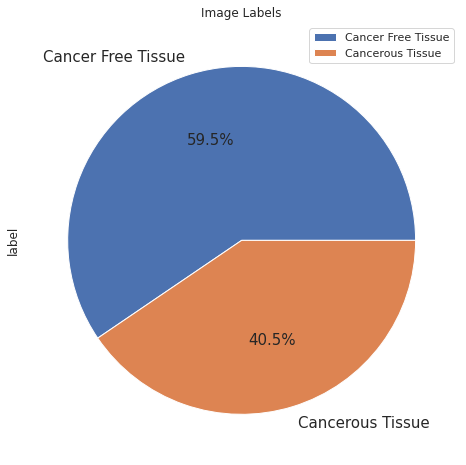

In [ ]:
sns.set(style='whitegrid')

# Here I change the label 0 to "Cancer Free Tissue" and 1 to "Cancerous Tissue"
pie_chart=pd.DataFrame(train_df['label'].replace(0,'Cancer Free Tissue').replace(1,'Cancerous Tissue').value_counts())
pie_chart.reset_index(inplace=True)

# Print out the chart
pie_chart.plot(kind='pie', title='Image Labels',y = 'label', 
             autopct='%1.1f%%', shadow=False, labels=pie_chart['index'], legend = True, fontsize=15, figsize=(18,8))

We can now visualize some of the data here.

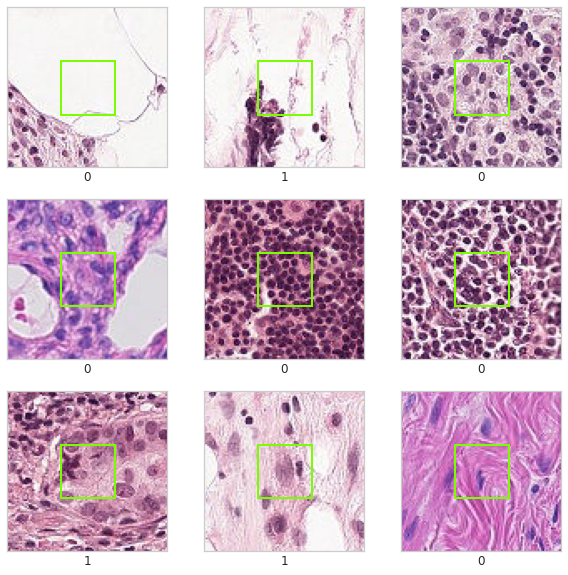

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i, axis in enumerate(ax.flat):
  file = str("./project/train/" + train_df.id[i] + '.tif')
  image = imageio.imread(file)
  test_box = matplotlib.patches.Rectangle((32,32),32,32, linewidth=2, edgecolor='lawngreen',facecolor='none', linestyle='-')
  axis.imshow(image)
  axis.add_patch(test_box)
  axis.set(xticks=[], yticks=[], xlabel = train_df.label[i]);

#2b. Processing Data
Below we begin to process our data. We split our training data into training and validation, and create data loaders for all of our data subsets.

Directly below you can see a class called `CancerDataset` this is something we implemented from a similar Kaggle project. We were getting inspiration for our project and decided that it would feel mundane to rewrite the wheel here and create our own dataset class.

Work Done By: Aidan Daly

In [ ]:
class CancerDataset(Dataset):
  def __init__(self, datafolder, datatype='train', transform = transforms.Compose([transforms.ToTensor()]), labels_dict={}):
    self.datafolder = datafolder
    self.datatype = datatype
    self.image_files_list = [s for s in os.listdir(datafolder)]
    self.transform = transform
    self.labels_dict = labels_dict
    if self.datatype == 'train':
        self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
    else:
        self.labels = [0 for _ in range(len(self.image_files_list))]

  def __len__(self):
    return len(self.image_files_list)

  def __getitem__(self, idx):
    img_name = os.path.join(self.datafolder, self.image_files_list[idx])
    image = Image.open(img_name)
    image = self.transform(image)
    img_name_short = self.image_files_list[idx].split('.')[0]

    if self.datatype == 'train':
        label = self.labels_dict[img_name_short]
    else:
        label = 0
    return image, label

In [ ]:
# Data Preprocess
data_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean=[.5], std=[.5])
])

img_class_dict = {k:v for k, v in zip(train_df.id, train_df.label)}
train, val = train_test_split(train_df.label, stratify=train_df.label, test_size=0.1)
train, test_label = train_test_split(train_df.label, stratify=train_df.label, test_size=0.1)
dataset = CancerDataset(datafolder='./project/train', datatype='train', transform=data_transform, labels_dict=img_class_dict)
test_dataset = CancerDataset(datafolder='./project/test/', datatype='test', transform=data_transform)

# Declare Batch Size and get Samples
BATCH_SIZE = 128
train_size_small = int(len(train)/6)
train_size_large = int(len(train)/2)
train_sampler_full = SubsetRandomSampler(list(train.index)) # train sampler for full datset
train_sampler_large = SubsetRandomSampler(list(train[:train_size_large].index)) # train sampler for large dataset
train_sampler_small = SubsetRandomSampler(list(train[:train_size_small].index)) # train sample for small dataset
valid_sampler = SubsetRandomSampler(list(val.index))
test_label_sampler = SubsetRandomSampler(list(test_label.index))
num_workers = 0

# Training, Validation, and Test Dataloader
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler_small, num_workers=num_workers)
valid_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=num_workers)
test_label_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_label_sampler, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=num_workers)


#3. Model
We decided to use a Convolutional Neural Network (CNN) as our model. Below you can see our models class. We used 4 convolutional layers and one fully connected layer.

Our model is also inspired by a few different projects we found online, which we combined together with our own knowledge as well as previous works in Psets 3 and 4.

Work done by: Aidan Daly and Matt Smallhouse

In [ ]:
class Flatten(nn.Module):
  def forward(self, x):
    N, C, H, W = x.size() # read in N, C, H, W
    return x.view(N, -1)

class Net(nn.Module):

  def flatten(self, x):
    N, C, H, W = x.size() # read in N, C, H, W
    return x.view(N, -1)

  def __init__(self):
    super(Net, self).__init__()

    out_1 = 32
    out_2 = 64
    out_3 = 128
    out_4 = 256

    k_size_1 = 3
    padding_1 = 1

    self.layer1 = nn.Sequential(
      nn.Conv2d(3, out_1, padding= padding_1, kernel_size=k_size_1, stride=1), 
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(out_1),
      nn.Conv2d(out_1 , out_1, padding= padding_1, kernel_size=k_size_1, stride=1), 
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(out_1),
      nn.Conv2d(out_1 , out_1, padding= padding_1, kernel_size=k_size_1, stride=1), 
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(out_1),
      nn.MaxPool2d(2, stride=2))

    self.layer2 = nn.Sequential(
      nn.Conv2d(out_1 , out_2, padding= padding_1, kernel_size=k_size_1, stride=1), 
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(out_2),
      nn.Conv2d(out_2 , out_2, padding= padding_1, kernel_size=k_size_1, stride=1), 
      nn.ReLU(inplace=True), 
      nn.BatchNorm2d(out_2),
      nn.Conv2d(out_2 , out_2, padding= padding_1, kernel_size=k_size_1, stride=1), 
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(out_2),
      nn.MaxPool2d(2, stride=2))

    self.layer3 = nn.Sequential(
      nn.Conv2d(out_2 , out_3, padding= padding_1, kernel_size=k_size_1, stride=1),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(out_3),
      nn.Conv2d(out_3 , out_3, padding= padding_1, kernel_size=k_size_1, stride=1), 
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(out_3),
      nn.Conv2d(out_3 , out_3, padding= padding_1, kernel_size=k_size_1, stride=1), 
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(out_3),
      nn.MaxPool2d(2, stride=2))
    
    self.layer4 = nn.Sequential(
      nn.Conv2d(out_3 , out_4, padding= padding_1, kernel_size=k_size_1, stride=1), 
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(out_4),
      nn.Conv2d(out_4 , out_4, padding= padding_1, kernel_size=k_size_1, stride=1), 
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(out_4),
      nn.Conv2d(out_4 , out_4, padding= padding_1, kernel_size=k_size_1, stride=1), 
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(out_4),
      nn.MaxPool2d(2, stride=2))

    self.fc = nn.Sequential(
      nn.Linear(9216,512 ), 
      nn.ReLU(inplace=True),
      nn.Linear(512,10), 
      nn.ReLU(inplace=True),
      nn.Linear(10,2))

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x

#4a. Training

Here we train our model and run it on our validation set.

`train` is our training function. We train our model on 1/4 the train set size because the dataset is so large. We run it through 6 epochs. It does take about 5 minutes to run on the GPU.

`check_accuracy` is our validation function. We use `model.eval` to put our model into a testing state. We validate and test the accuracy of our model with the validation data after every epoch. This data comes from the training set but is a much smaller size. 


If you would like to test out training our model for yourself feel free to uncomment out the region below above where it says `train(...)`.

Work done by: Matthew Smallhouse and Aidan Daly

In [ ]:
# Below Work Done by Matt

NUM_EPOCHS = 30

lr = 0.01
model = Net()
loss_fn = nn.modules.loss.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

avg_loss_list = []
acc_list = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


def train(model, train_loader ,loss_fn, optimizer, num_epochs = 1):
  total_loss = 0
  print_every = 10
  for epoch in range(num_epochs):
    print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
    model.train()
    for t, (x, y) in enumerate(train_loader):
      x_var = x.to(device)
      y_var = y.to(device)

      scores = model(x_var)
      loss = loss_fn(scores, y_var)
      total_loss += loss.data
      if (t + 1) % print_every == 0:
        avg_loss = total_loss/print_every
        print('t = %d, avg_loss = %.4f' % (t + 1, avg_loss) )
        avg_loss_list.append(avg_loss)
        total_loss = 0
          
        #Below: Work Done by Aidan
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = check_accuracy(model, valid_loader)
    print('acc = %f' %(acc))
    # The below commented out code was used for saving our trained model to Google Drive - Aidan
    # if epoch %5 == 0:
    #   model_save_name = 'classifier.pt'
    #   path = f"drive/My Drive/{model_save_name}" 
    #   torch.save(model.state_dict(), path)



# Below work done by Aidan
def check_accuracy(model, loader):
  print('Checking accuracy on current set')   
  num_correct = 0
  num_samples = 0
  model.eval() # Puts the model in test mode
  for x, y in loader:
    x_var= x.to(device)

    scores = model(x_var)
    _, preds = scores.data.cpu().max(1)
    num_correct += (preds == y).sum()
    num_samples += preds.size(0)
    
    acc = float(num_correct) / num_samples
    acc_list.append(acc)
    return acc
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

# Uncomment region below to run the model
# train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler_small, num_workers=num_workers)

# train(model, train_loader, loss_fn, optimizer, NUM_EPOCHS)




#4b. Training Visualization
Below you will see a plot of the accuract of our model over 75 epochs using one sixth of our dataset. This resulted in a little under 96% accuracy. As you can see it increases fast in the beginning and very slowly after around epoch 20.

Our full model which you will be able to download in the next section was run for 30 epochs on the full dataset. This resulted in around 98% accuracy.

In [ ]:
! pip install -U --no-cache-dir gdown --pre
! gdown 1ymzI-HttkOx-jUNVMmgR0qCQbS1b3ayT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1ymzI-HttkOx-jUNVMmgR0qCQbS1b3ayT
To: /content/accuracy_list.txt
100% 1.41k/1.41k [00:00<00:00, 2.76MB/s]


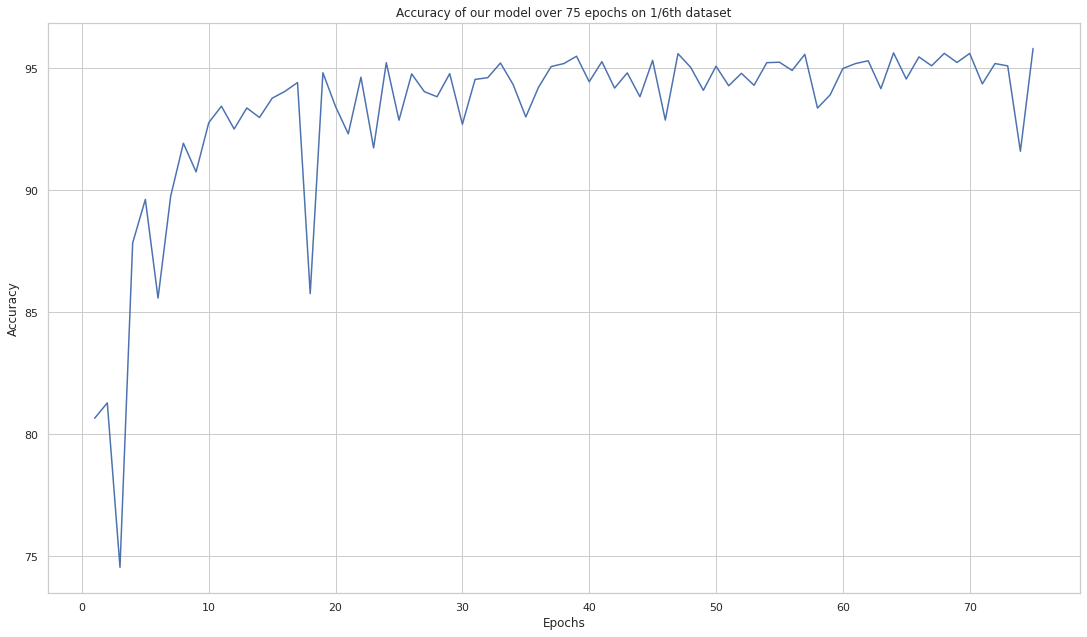

In [ ]:
# Work done by Aidan Daly
acc_list = []
f = open("accuracy_list.txt")
accuracies = f.readlines()
for line in accuracies:
  line = line.strip()
  line = float(line) * 100
  acc_list.append(line)


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
x_axis = range(1, 75+1)
plt.plot(x_axis, acc_list)
plt.title("Accuracy of our model over 75 epochs on 1/6th dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
sns.set()
plt.show()

#5. Testing

Below we test our model on labeled testing data that the model has never seen and receive an accuracy. 

We then get predictions on unlabeled data that we can visualize.

Work done by: Aidan Daly


In [ ]:
# This will download our model from Google Drive so you can test it
! gdown 1BqO1Tc_3fLvY9DdoixA-d0I-hebtDQLK

Downloading...
From: https://drive.google.com/uc?id=1BqO1Tc_3fLvY9DdoixA-d0I-hebtDQLK
To: /content/classifier.pt
100% 26.8M/26.8M [00:00<00:00, 213MB/s]


In [ ]:
model = Net()

path = "./classifier.pt"
model.load_state_dict(torch.load(path, map_location=torch.device(device)))
acc = check_accuracy(model.to(device), test_label_loader)
print('acc =%.2f' %(100 *acc))

Checking accuracy on current set
acc =99.22


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


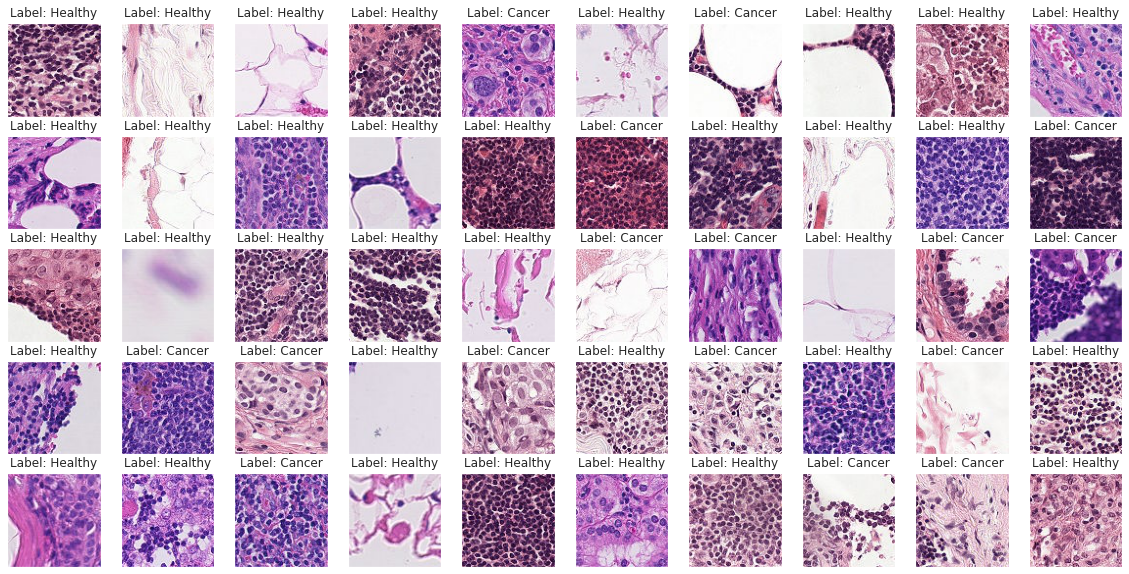

In [ ]:
unlabeled = pd.read_csv('./project/sample_submission.csv')
model.eval()

predictions = []

for i, (images, labels) in enumerate(tqdm(test_loader, total=int(len(test_loader)))):
  images = images.to(device)
  labels = labels.to(device)
  
  outputs = model(images)
  pred = outputs[:,1].detach().cpu().numpy()
  
  for j in pred:
      predictions.append(j)

unlabeled['label'] = predictions


test_images = np.random.choice(unlabeled.id, size=50, replace=False)     

fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
  for m in range(10):
    img_id = test_images[m + n*10]
    image = plt.imread('./project/test/' + img_id + ".tif")
    pred = unlabeled.loc[unlabeled['id'] == img_id, 'label'].values[0]
    label = "Cancer" if(pred >= 0.5) else "Healthy"  
    ax[n,m].imshow(image)
    ax[n,m].grid(False)
    ax[n,m].tick_params(labelbottom=False, labelleft=False)
    ax[n,m].set_title("Label: " + label)
      

#6. Filter Visualization
Below we get a random image from the dataset and push it through the model, saving the filter map after each layer of convolution. This helps to get a sense of how each layer is modifying an input image.

Code adapted from https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573

Work done by: Matt Smallhouse

In [ ]:
# we will save the conv layers and weights in these lists
model_weights =[]
conv_layers = []

# get all the model children as list
model_children = list(model.children())

counter = 0
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
  for j in range(len(model_children[i])):
    child = model_children[i][j]
    if type(child) == nn.Conv2d:    
      counter+=1
      model_weights.append(child.weight)
      conv_layers.append(child)

print(f"Total convolution layers: {counter}")

Total convolution layers: 12


In [ ]:
# transform an individual image to something we can push through the model
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=0., std=1.)
])

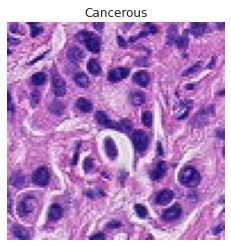

number of conv2d layers: 12


In [ ]:
# get a random image
idx = random.randrange(0, len(train_df.id), 1)
file = str("./project/train/" + train_df.id[idx] + '.tif')
image = imageio.imread(file)    
plt.imshow(image)
plt.axis('off')
if train_df.label[idx] == 1:
  plt.title("Cancerous")
else:
  plt.title("Cancer-free")

plt.show()

# transform and load to GPU if available
image = transform(image).to(device)
outputs = []
names = []
for layer in conv_layers[0:]:
  image = layer(image)
  outputs.append(image)
  names.append(str(layer))

print("number of conv2d layers:", len(outputs))

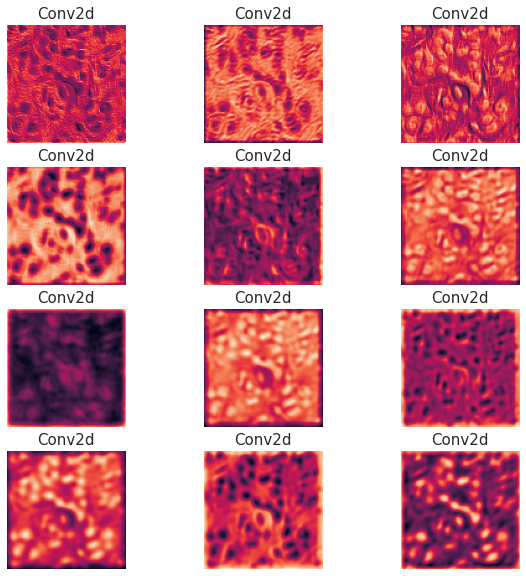

In [ ]:
processed = []
for feature_map in outputs:
  feature_map = feature_map.squeeze(0)
  gray_scale = torch.sum(feature_map,0)
  gray_scale = gray_scale / feature_map.shape[0]
  processed.append(gray_scale.data.cpu().numpy())

# display feature map after each conv2d layer
fig = plt.figure(figsize=(10, 10))
for i in range(len(processed)):
  a = fig.add_subplot(4, 3, i+1)
  imgplot = plt.imshow(processed[i])
  a.axis("off")
  a.set_title(names[i].split('(')[0], fontsize=15)